#Yewno Data Challenge
##Helen Craig
##Jan 14, 2015
You are given a realworld
undirected semantic graph represented via an adjacency matrix
wherein links encode similarity between concepts. You are asked to explore the ( emerging )
properties of such a graph (aka network ) in terms of its embedding on a surface with a given
genus by using the techniques provided in the references attached [<a href="Exploring_complex_networks_via_embedding_on_surfaces.pdf">1</a> ,<a href="Random_and_frozen_states_in_complex_triangulations.pdf">2</a>]. You are also asked to
infer potential connections between properties of hyperbolic embeddings and semantic
information hidden in the network.

##Paper Summary
In the two papers given as reference, the authors explore complex networks by modeling the system as a statistical mechanical description and manipulate the system via a 'temperature'.

##Reproducing Results
The following code reproduces some of the methods used in the above mentioned papers:

In [2]:
import csv
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

###Function for loading the data

In [3]:
def loadData(name="net1.dat",n=10000):#this function loads the data
    entries = list(csv.reader(open(name, 'rb'),delimiter='\t'))[0:n]
    dic={}
    for entry in entries:
        dic[(entry[0],entry[1])]=entry[2]
    dicSingles={}#we create a dictionary where the keys are the
    for key in dic.keys():#various words and the items are the 
        if key[0] in dicSingles.keys():#words connected to the keys
            if key[1] not in dicSingles[key[0]]:
                dicSingles[key[0]].append(key[1])
        else:
            dicSingles[key[0]]=[key[1]]

        if key[1] in dicSingles.keys():
            if key[0] not in dicSingles[key[1]]:
                dicSingles[key[1]].append(key[0])
        else:
            dicSingles[key[1]]=[key[0]] 
    dicDoubles={}#we create a dictionary where the key is a edge
    for key in dicSingles.keys():#and the items are the 
        for item in dicSingles[key]:#
            a=key
            b=item
            if a>b:
                c=a
                a=b
                b=c 
            newItems=list(set(dicSingles[a]).intersection(dicSingles[b]))
            if (a,b) not in dicDoubles.keys():
                    dicDoubles[(a,b)]=newItems
    return (dicSingles,dicDoubles)

###Function for calculating the average k
Here k is the number of incident edges for a given vertex

In [4]:
def calcKavrg(dicSingles):
    tot=0
    for item in dicSingles.items():
        tot+=len(item[1])
    return float(tot)/float(len(dicSingles))

###Function for calculating energy of the graph
The energy is defined as: $E=\sum^n_{i=1}(k_i-\bar{k})^2$ where n is the number of vertices and $\bar{k}$ is the average k value.

In [5]:
def calcEnergy(dicSingles,kAvg):
    tot=0
    for item in dicSingles.items():
        tot+=pow(len(item[1])-kAvg,2)
    return tot

###Helper function for organizing keys for edge array

In [6]:
def reorder(a,b):
    if a>b:
        c=a
        a=b
        b=c
    return a,b

###Function for removing one edge and inserting another edge
This is the move T1 discussed in the linked papers.  Visually the move is:
<img src="T1.png">

In [7]:
def makeMove(dicSingles,dicDoubles,oldLink,newLink):
    del dicDoubles[oldLink]#delete the link
    dicSingles[oldLink[0]].remove(oldLink[1])#remove link
    dicSingles[oldLink[1]].remove(oldLink[0])#from the two previously linked nodes
    for item in dicSingles[oldLink[0]]:#for one of the old nodes
        a=oldLink[0]#remove the link to the third node
        b=item
        a,b=reorder(a,b)
        if (a,b) in dicDoubles.keys():
            if oldLink[1] in dicDoubles[(a,b)]:
                dicDoubles[(a,b)].remove(oldLink[1])
    for item in dicSingles[oldLink[1]]:#same for the other node
        a=oldLink[1]
        b=item
        a,b=reorder(a,b)
        if (a,b) in dicDoubles.keys():
            if oldLink[0] in dicDoubles[(a,b)]:
                dicDoubles[(a,b)].remove(oldLink[0])
    #########################################       
    dicSingles[newLink[0]].append(newLink[1])#add the new link to the 
    dicSingles[newLink[1]].append(newLink[0])#individual lists
    a=newLink[0]
    b=newLink[1]
    a,b=reorder(a,b)
    newItems=list(set(dicSingles[a]).intersection(dicSingles[b]))
    dicDoubles[(a,b)]=newItems#add to the link list and the third connections
    for item in dicSingles[newLink[0]]:
        a,b=reorder(item,newLink[0])
        newItems=list(set(dicSingles[a]).intersection(dicSingles[b]))
        dicDoubles[(a,b)]=newItems#add to the link list the any other new connections
    for item in dicSingles[newLink[1]]:
        a,b=reorder(item,newLink[1])
        newItems=list(set(dicSingles[a]).intersection(dicSingles[b]))
        dicDoubles[(a,b)]=newItems#same with the other new point      

###Function for stepping through the graph to make suggested moves.  
This function steps through the graph looking for edges where a T1 move is possible.  If one is found, the change in energy of such a move is calculated ($\Delta E=2(k_a+k_c-k_b-k_d)+4$) and is accepted with probability $\frac{1}{1+\exp{(\beta \Delta E)}}(1-\delta_{k_b,3})(1-\delta_{k_d,3})(1-\delta_{a,c})$ where $T=1/\beta$, a 'temperature' of the system.

In [14]:
def stepThroughGraph(dicSingles,dicDoubles,beta):
    totE=0
    totMoves=0
    oldKeys=dicDoubles.keys()#list of old links
    for oldKey in oldKeys:#step through them
        oldTriangles=dicDoubles[oldKey]#list of triangles that the link is a part of
        if len(dicSingles[oldKey[0]])>3 and len(dicSingles[oldKey[1]])>3 and len(oldTriangles)>1:
            for oldTriangleIndex in range(len(oldTriangles)):
                r1=random.randrange(0, len(oldTriangles))#randomly select two of the triangles
                r2=random.randrange(0, len(oldTriangles))
                if r1!=r2:#if they are not the same triangle
                    a,b=reorder(oldTriangles[r1],oldTriangles[r2])
                    if (a,b) not in dicDoubles.keys():#if the link does not already exist
                        ka=len(dicSingles[oldTriangles[r1]])
                        kc=len(dicSingles[oldTriangles[r2]])
                        kd=len(dicSingles[oldKey[0]])
                        kb=len(dicSingles[oldKey[1]])
                        deltaE=2*(ka+kc-kd-kb)+4#calc the change in energy
                        totE+=deltaE
                        if deltaE/beta>200:
                            prob=0
                        else:    
                            prob=1/(1+math.exp(deltaE/beta))
                        r=random.random()
                        totMoves+=1
                        if prob>r:#calc if we make the move
                                oldLink=oldKey
                                newLink=(oldTriangles[r1],
                                        oldTriangles[r2])#make the move
                                makeMove(dicSingles,dicDoubles,oldLink,newLink)
                                break;#exit the loop
    #print float(totE)/float(totMoves)
    return totMoves


###Function for calculating the genus of a given graph

In [9]:
def calcGenus(dicSingles,dicDoubles):
    numVertices=len(dicSingles)
    numEdges=len(dicDoubles)
    numTriangles=0
    for key in dicDoubles.keys():
        numTriangles+=len(dicDoubles[key])
    return 1-(numVertices-numEdges+numTriangles/3)/2.0

###Load the file and calculate the average k and the energy of the system

In [10]:
dicSingles,dicDoubles=loadData("net1.dat",10000)#load data
kAvg=calcKavrg(dicSingles)#calc kAvg
print kAvg
print calcEnergy(dicSingles,kAvg)

5.10176017602
457570.348735


###function for calculating the number of vertices, edges, and triangles of a graph

In [11]:
def CalcVerticesEdgesTrianglesGenus(dicSingles,dicDoubles):
    numVertices=len(dicSingles)
    numEdges=len(dicDoubles)
    numTriangles=0
    for key in dicDoubles.keys():
        numTriangles+=len(dicDoubles[key])
    print "# vertices",numVertices
    print "# edges",numEdges
    print "# triangles",numTriangles,"/ 3 =",numTriangles/3
    print "# genus",1-(numVertices-numEdges+numTriangles/3)/2.0
CalcVerticesEdgesTrianglesGenus(dicSingles,dicDoubles)

# vertices 3636
# edges 9275
# triangles 7062 / 3 = 2354
# genus 1643.5


###running the code for different $\beta$

below is the code for running the simulation with different $\beta$ values.  Only 50 sweeps through the graph are made because of the long running time (~10min).  

In [15]:
betas=['10','1','0.1','0.01','0.001','0.000001']
steps=range(50)
energyArray={'10':[],'1':[],'0.1':[],'0.01':[],'0.001':[],'0.000001':[]}
stepsArray={'10':[],'1':[],'0.1':[],'0.01':[],'0.001':[],'0.000001':[]}
for beta in betas:
    totSteps=0
    dicSingles,dicDoubles=loadData("net1.dat",10000)#load data
    for step in steps:
        totSteps+=stepThroughGraph(dicSingles,dicDoubles,float(beta))
        energyArray[beta].append(calcEnergy(dicSingles,kAvg)/len(dicSingles))
        stepsArray[beta].append(totSteps)
        #print beta,step,totSteps,calcEnergy(dicSingles,kAvg), calcGenus(dicSingles,dicDoubles)

###plot for different betas, evolution of energy versus steps.

From the plot below we see that the energy is still decreasing for the $\beta$'s, most notably for $\beta=10$.

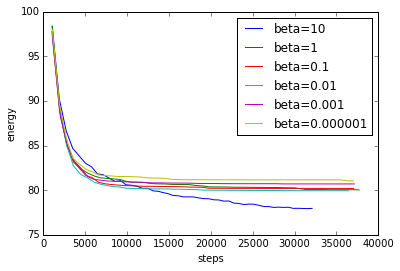

In [16]:
for beta in betas:
    plt.plot(stepsArray[beta],energyArray[beta],label='beta='+beta)
    plt.xlabel('steps')
    plt.ylabel('energy')
    plt.legend()
plt.show()

###The final energy versus $\beta$

The final energy decreases for smaller temperatures (larger $\beta$).

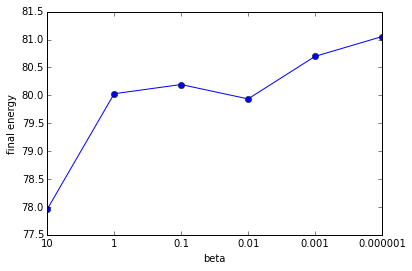

In [17]:
x=range(len(betas))
plt.plot(x,[energyArray[beta][-1] for beta in betas],'o-')
plt.xticks(x, betas)
plt.xlabel('beta')
plt.ylabel('final energy')

###Simulated annealing
We can also try doing a simulated annealing scheme.

In [18]:
steps=range(300)
beta=0.1
dicSingles2,dicDoubles2=loadData("net1.dat",10000)#load data
energyArray2=[]
stepsArray2=[]
betaMult=1.05
totSteps2=0
for step in steps:
    totSteps2+=stepThroughGraph(dicSingles2,dicDoubles2,beta)
    energyArray2.append(calcEnergy(dicSingles2,kAvg)/len(dicSingles2))
    stepsArray2.append(totSteps2)
    beta=beta*betaMult
    #print step,beta,totSteps2,calcEnergy(dicSingles2,kAvg)/len(dicSingles2), calcGenus(dicSingles2,dicDoubles2)

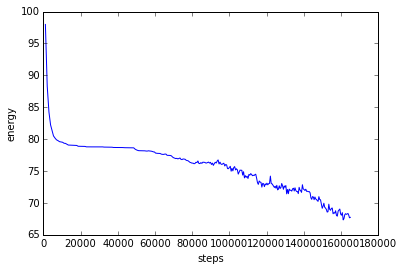

In [19]:
plt.plot(stepsArray2,energyArray2)
plt.xlabel('steps')
plt.ylabel('energy')

###Dataset 2
We can do a similar analysis on the second data set:

In [20]:
betas=['10','1','0.1','0.01','0.001','0.000001']
steps=range(50)
energyArray={'10':[],'1':[],'0.1':[],'0.01':[],'0.001':[],'0.000001':[]}
stepsArray={'10':[],'1':[],'0.1':[],'0.01':[],'0.001':[],'0.000001':[]}
for beta in betas:
    totSteps=0
    dicSingles,dicDoubles=loadData("net2.dat",10000)#load data
    for step in steps:
        totSteps+=stepThroughGraph(dicSingles,dicDoubles,float(beta))
        energyArray[beta].append(calcEnergy(dicSingles,kAvg)/len(dicSingles))
        stepsArray[beta].append(totSteps)


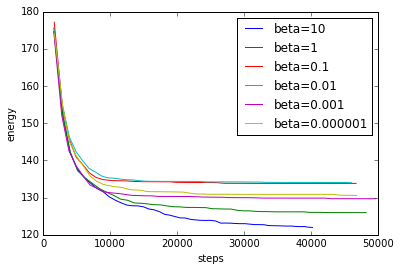

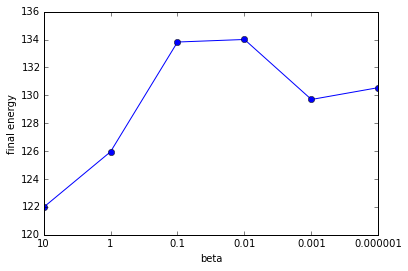

In [21]:
for beta in betas:
    plt.plot(stepsArray[beta],energyArray[beta],label='beta='+beta)
    plt.xlabel('steps')
    plt.ylabel('energy')
    plt.legend()
plt.show()

x=range(len(betas))
plt.plot(x,[energyArray[beta][-1] for beta in betas],'o-')
plt.xticks(x, betas)
plt.xlabel('beta')
plt.ylabel('final energy')
plt.show()

In [22]:
steps=range(300)
beta=0.1
dicSingles2,dicDoubles2=loadData("net2.dat",10000)#load data
energyArray2=[]
stepsArray2=[]
betaMult=1.05
totSteps2=0
for step in steps:
    totSteps2+=stepThroughGraph(dicSingles2,dicDoubles2,beta)
    energyArray2.append(calcEnergy(dicSingles2,kAvg)/len(dicSingles2))
    stepsArray2.append(totSteps2)
    beta=beta*betaMult

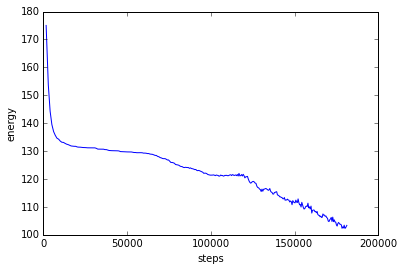

In [23]:
plt.plot(stepsArray2,energyArray2)
plt.xlabel('steps')
plt.ylabel('energy')

###Conclusions

A statistical physics framework can be used to decrease the number of edges in a graph by means of a temperature.  This has important implications for information filtering. 

Further, one can use common techniques such as simulated annealing, parallel tempering (e.g. http://people.math.umass.edu/~rsellis/pdf-files/parallel-tempering-paper.pdf), or perhaps a modified diffusion monte carlo method (e.g. http://arxiv.org/pdf/physics/9702023v1.pdf).

Overall, I was limited by the memory on my laptop.  One solution to this would be using a AWS machine to do my work.

Further this work could also be parallelized using C++ MPI library.  In genral, the algorithms will run faster if implemented in C++ or C.  The data could be divided up into clusters and processed on seperate cores.